In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# To read and analyse $P_{\alpha}$ data generated from RASCAS only for generating the radial profile, i.e., $P_{\alpha}(r)$ vs $r$.

I am reserving the following code to analyse the system with Semelin et al (2007) like setup.
- Hubble expanding medium at $z=10.0094$ so that `fix_nhi = 2.546e-4`
- Sphere radius 100 cMpc and `comput_dom_rsp = 0.499`, so that `fix_box_size_cm = 5.62e25`
- `RASCAS` run on `hydro-cool3/output_00013`
- Gas temperature at $30\,$K so that `fix_vth = 70656.21`

Base level of RAMSES simulation = 8


<IPython.core.display.Javascript object>


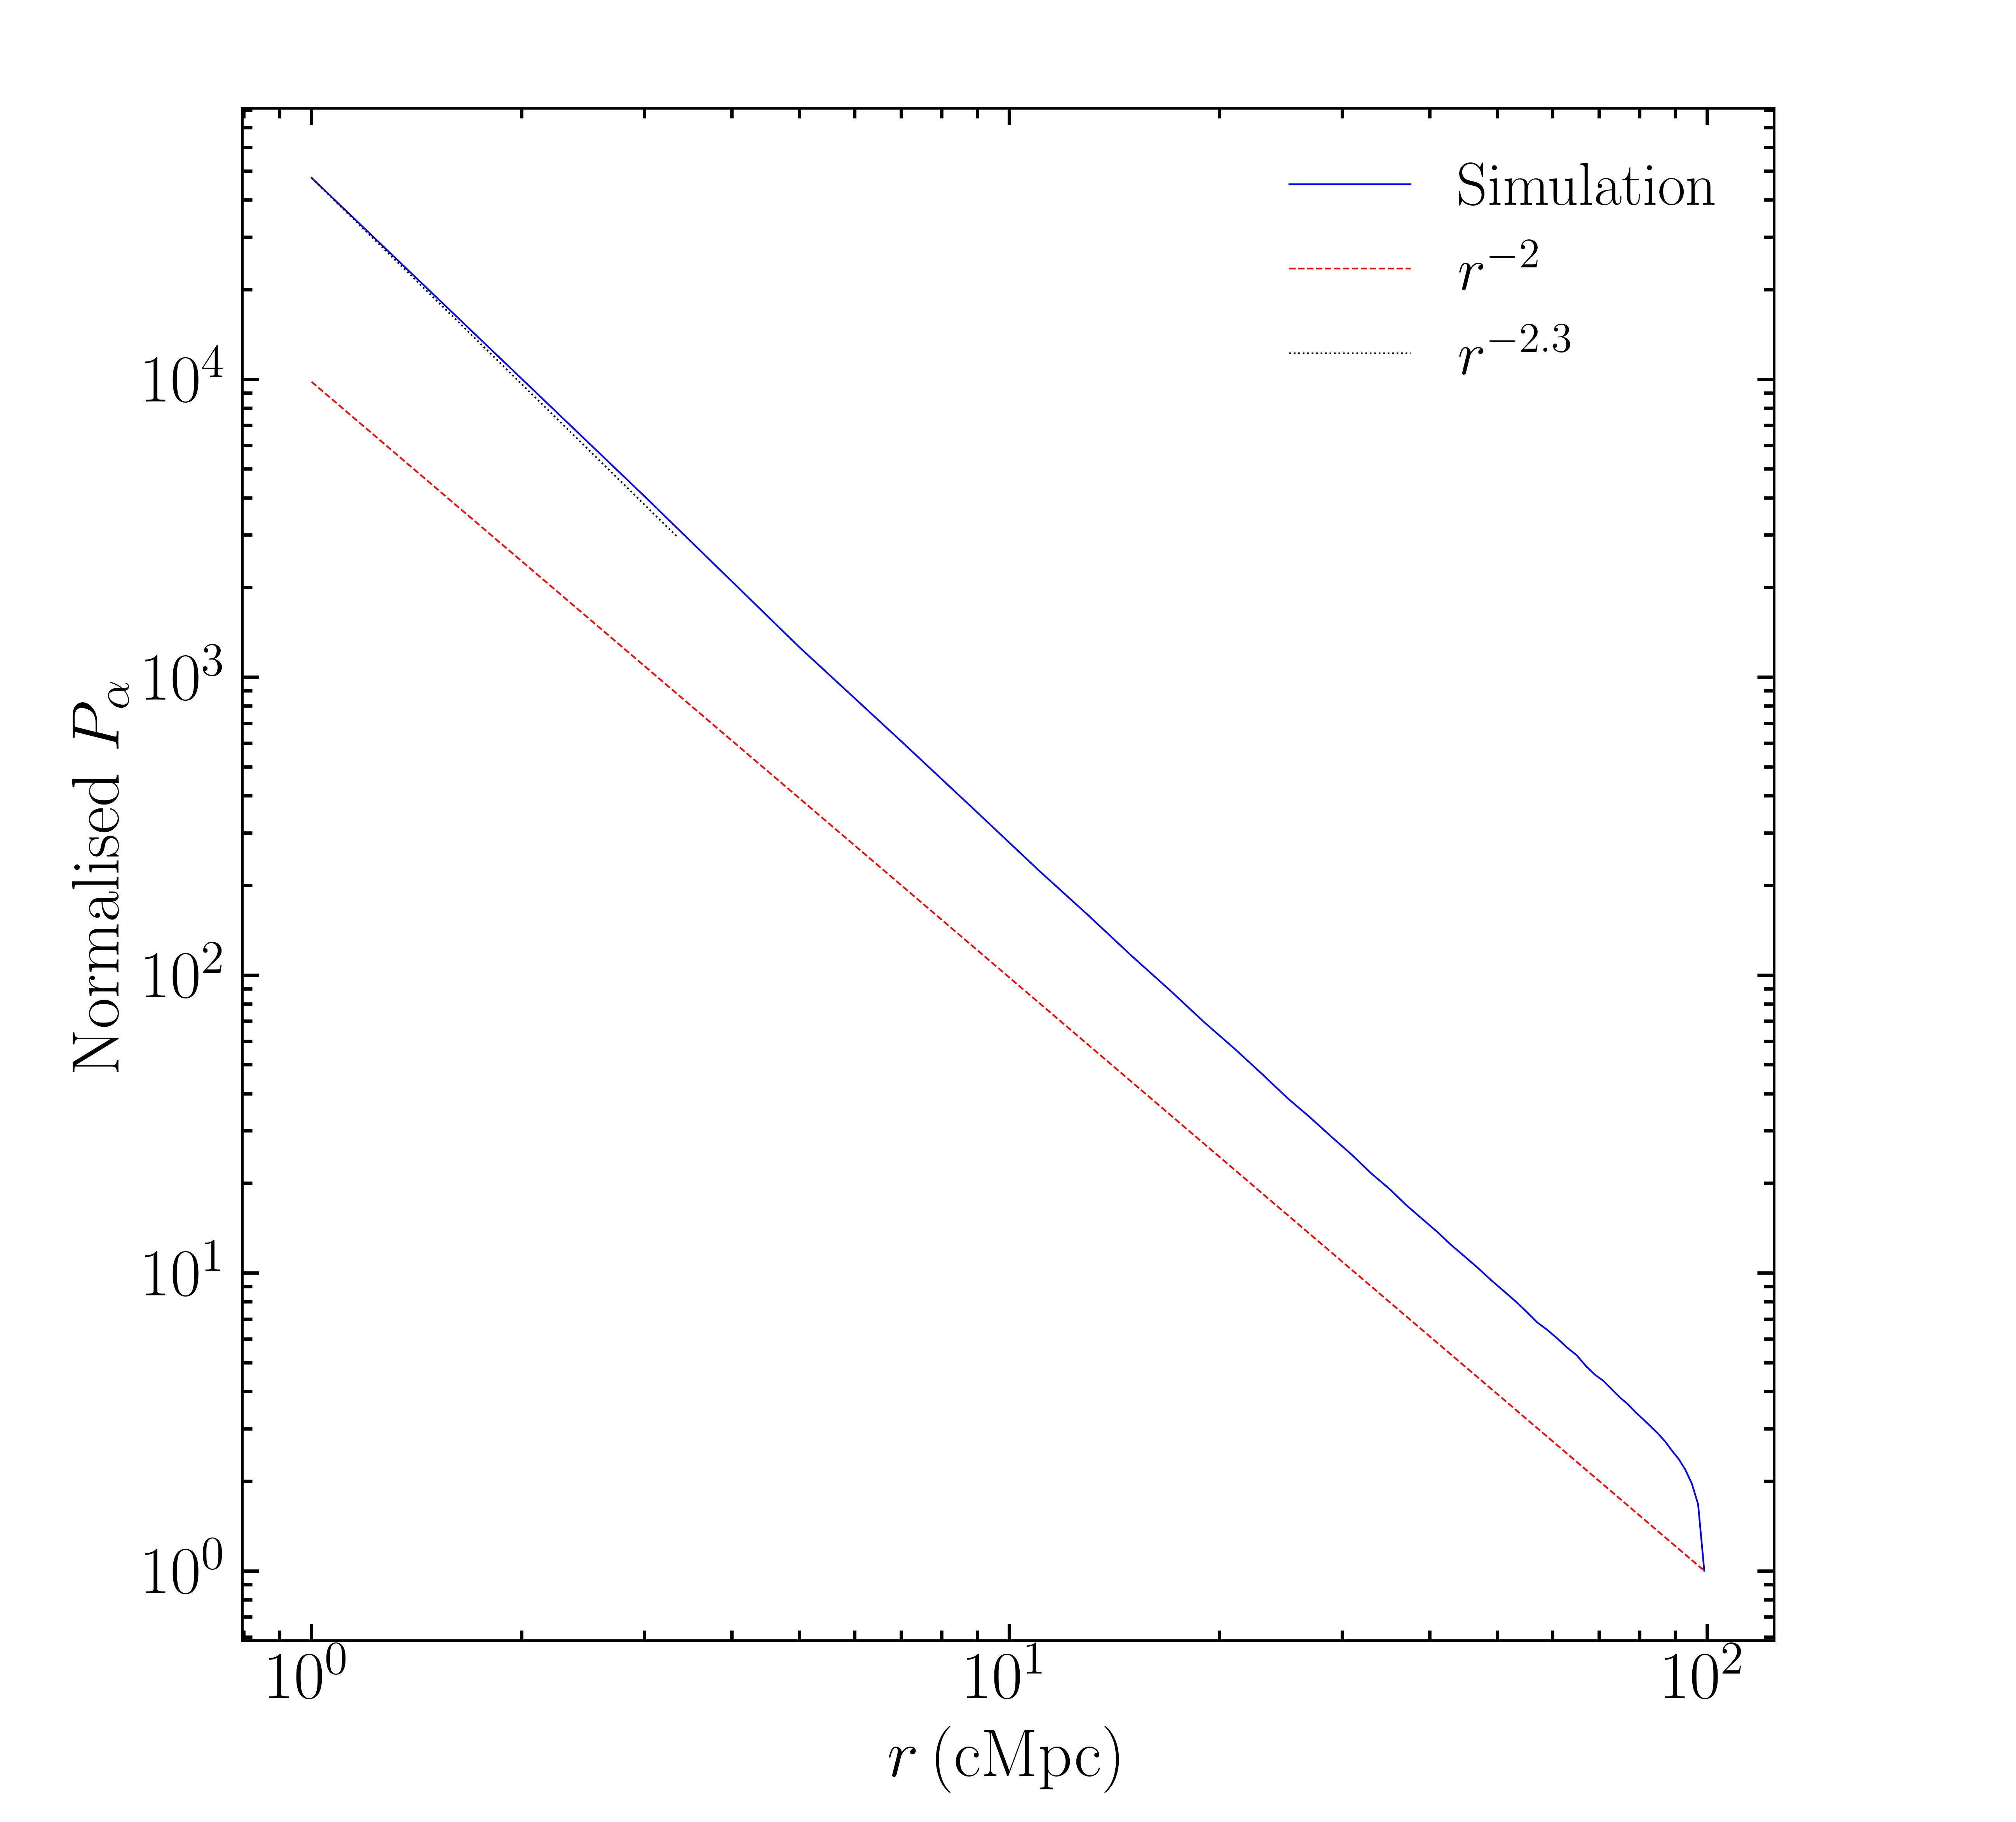

In [4]:
import numpy as np
from scipy.io import FortranFile as ff
import matplotlib.pyplot as plt
#%matplotlib notebook

#Full path to raw palpha data generated by RASCAS.
fn='/home/shikhar/work/Semelin/pa_p1e7_zerok.dat'
#fn='/home/shikhar/work/Semelin/pa_dirac_delta.dat'

f = ff(fn)

[lev] = f.read_ints()	#I had set the first level of binary data to be the base level of RAMSES simulation.
raw = f.read_reals('d')	#The second level is the palpha data.
np.nan_to_num(raw,copy=False)	#Replacing nan with 0's for ease of plotting.

print('Base level of RAMSES simulation =',lev)

palpha=np.reshape(raw,[2**lev,2**lev,2**lev],order='F')

cell_size = 2.0**(-lev)
x=np.linspace(cell_size/2,1-cell_size/2,2**lev)
y=x
z=x
X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
X=X-0.5
Y=Y-0.5
Z=Z-0.5

R=np.sqrt(X**2+Y**2+Z**2)

rtilde = 0.499
nbins = 50
L = 200.495 #sphere radius in cMpc

rbins = np.linspace(0,rtilde,nbins+1)

radial_Pa = np.zeros(nbins)
cnt = np.zeros(nbins)

for i in range(nbins):
    loc = np.where((R <rbins[i+1]) & (R >rbins[i]))
    radial_Pa[i] = radial_Pa[i] + np.sum(palpha[loc])
    cnt[i]=cnt[i] + np.size(palpha[loc])

radial_Pa = radial_Pa/cnt

norm_palpha = radial_Pa/radial_Pa[-1]

rbins = L*rbins
r = (rbins[:-1]+rbins[1:])/2

rmax = max(r)
rmin = min(r)
rplot=np.linspace(rmin,rmax,1000)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig,ax=plt.subplots(figsize=(8.3,7.5),dpi=200)
fig.subplots_adjust(left=0.12, bottom=0.07, right=0.88, top=0.97)
ax.loglog(r,norm_palpha,color='b',lw=0.5,label='Simulation')

#Comparing with 1/r^2 at r>>1
ax.loglog(rplot, (rplot/rmax)**-2,'r--',lw=0.5,label='$r^{-2}$')

#Comparing with 1/r^2.3 at r>>1
ax.loglog(rplot[:25], max(norm_palpha)*(rplot[:25]/rmin)**-2.3,'k:',label='$r^{-2.3}$',lw=0.5)

ax.set_xlabel(r"$r\,$(cMpc)",fontsize=20)
ax.set_ylabel(r"Normalised $P_{\alpha}$",fontsize=20)
ax.tick_params(axis='both', which='major', length=5, width=1, labelsize=20,direction='in')
ax.tick_params(axis='both', which='minor', length=3, width=1,direction='in')
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
#ax.set_ylim([1e8,1e13])
#ax.set_xlim([0,1])
ax.legend(fontsize=18,frameon=False)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.show()
#plt.savefig('test_a2.pdf')
#print("Done. Plot saved as 'figure.pdf'.")

In [3]:
np.save('radial_pa_p1e7_zerok',norm_palpha)
#np.save('radial_pa_p1e7_dirac_delta',norm_palpha)

<IPython.core.display.Javascript object>


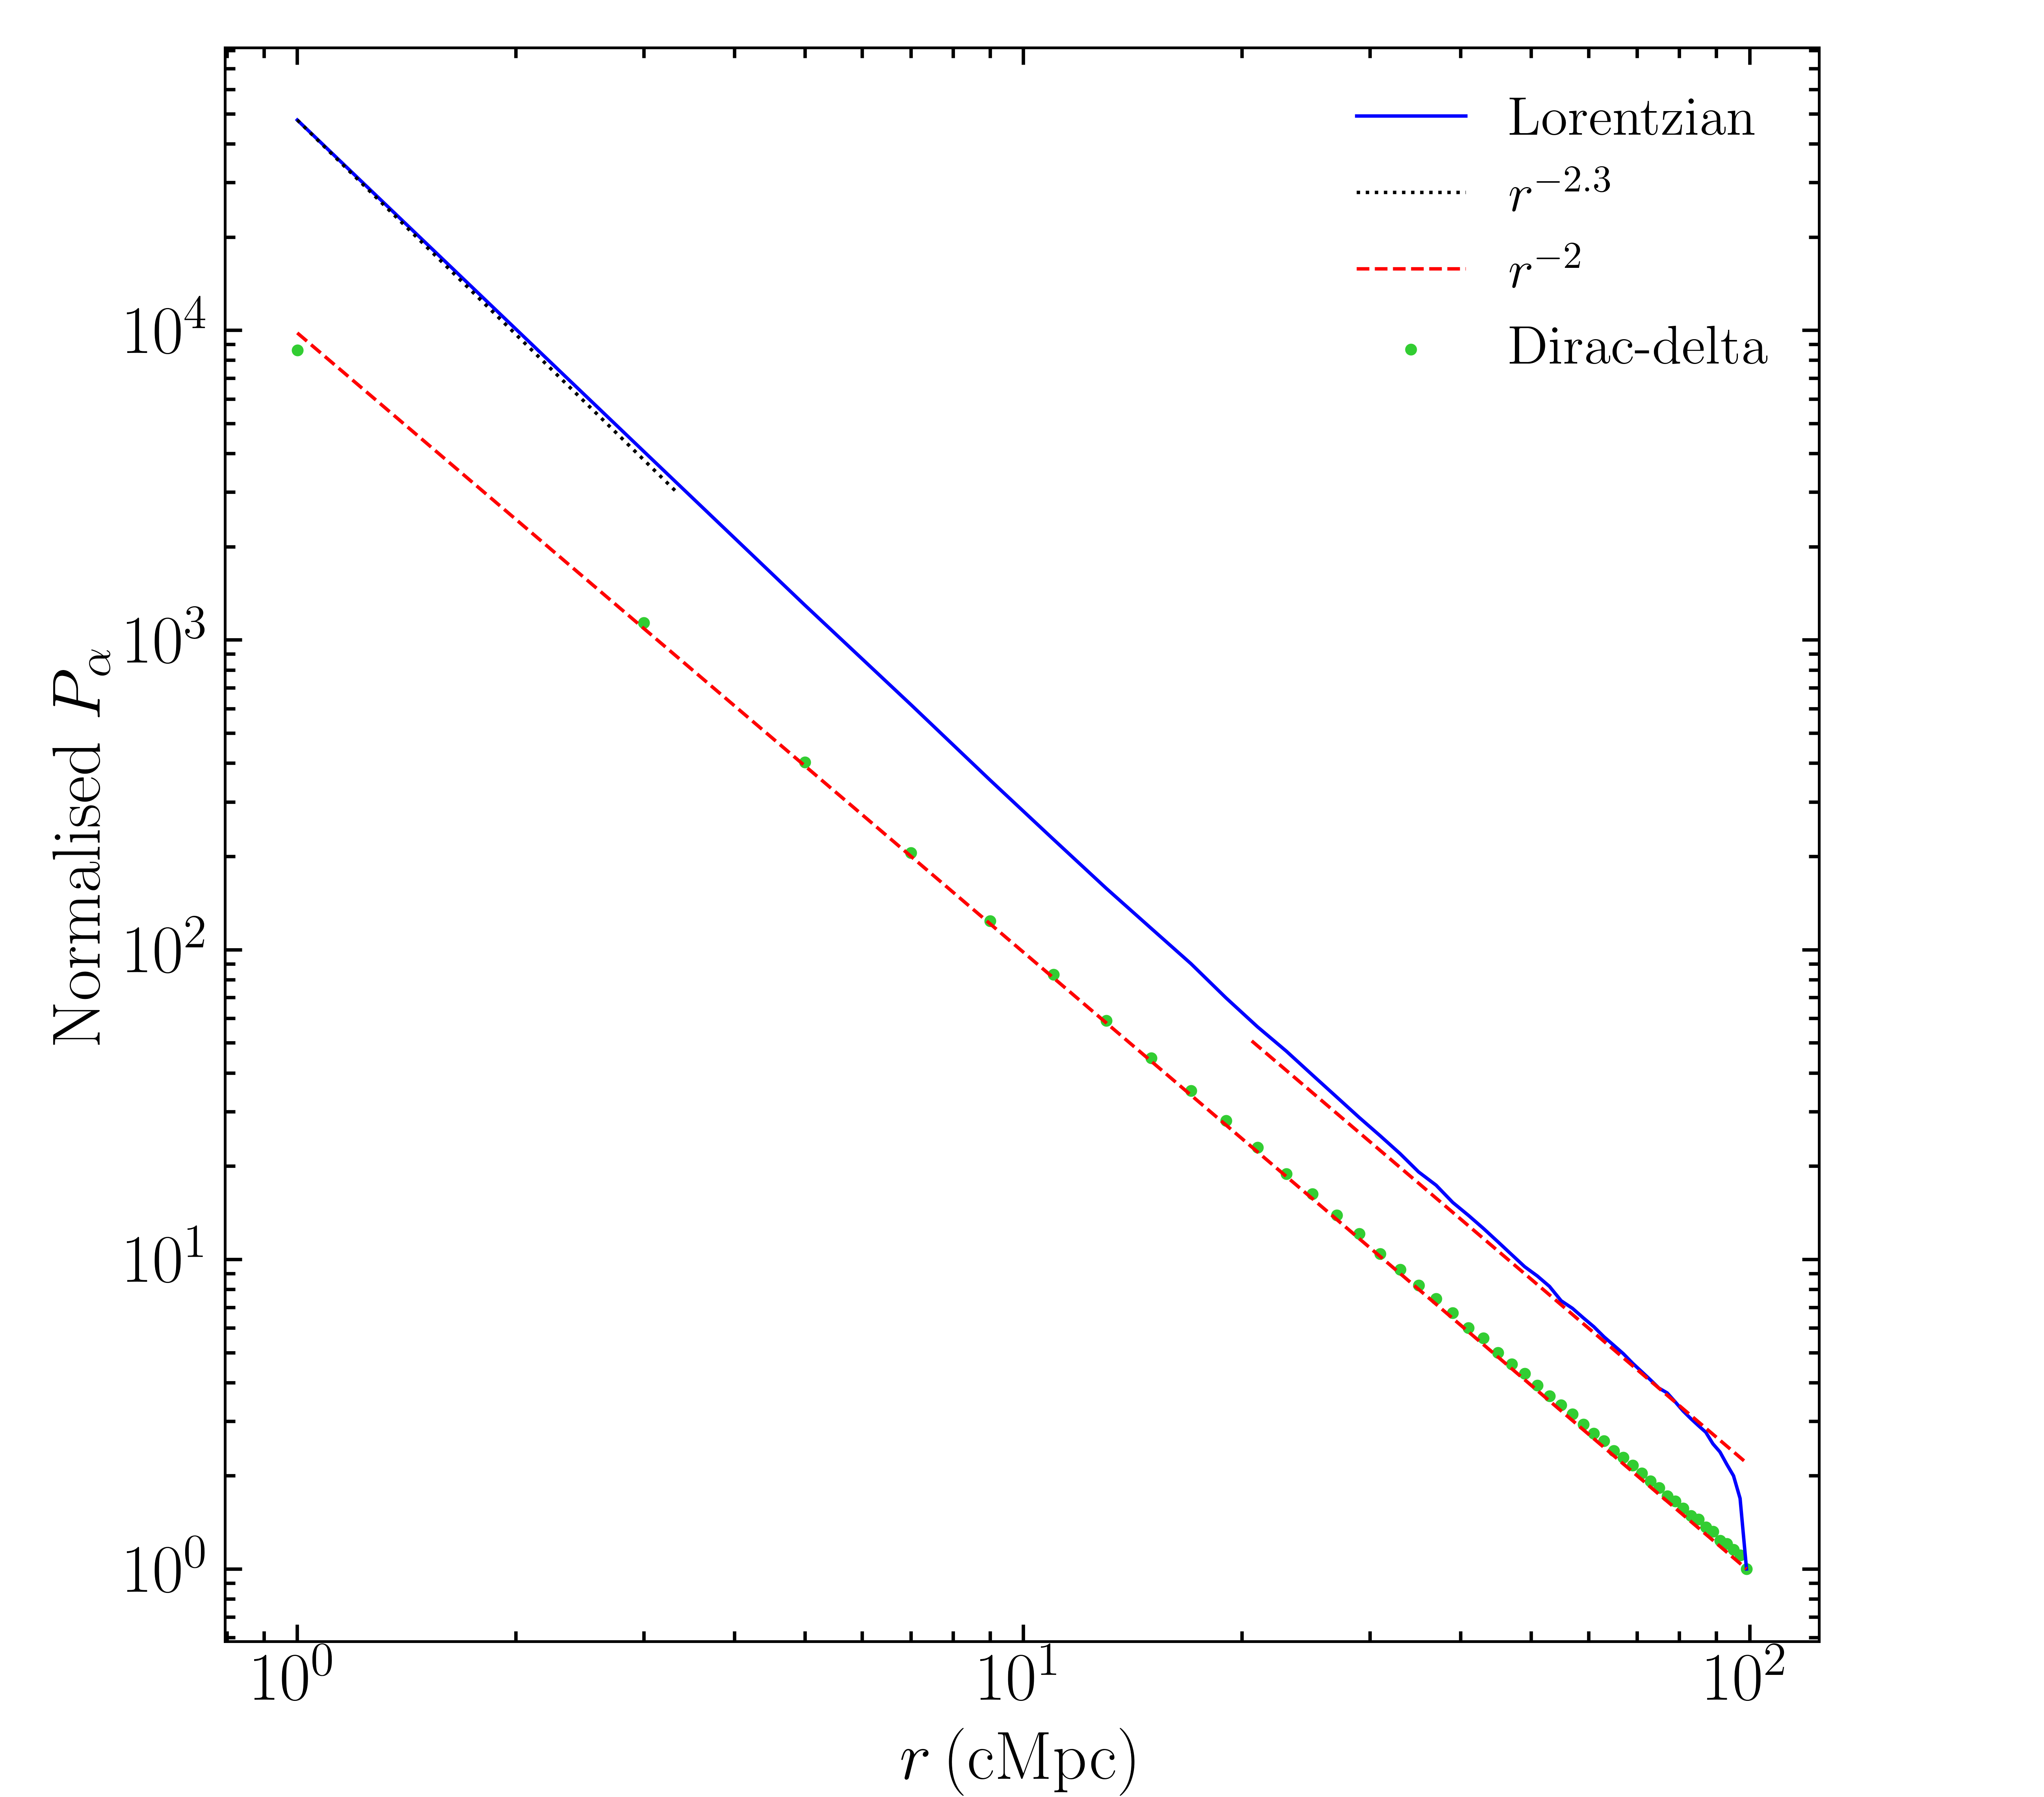

In [5]:
import numpy as np
import matplotlib.pyplot as plt

p1 = np.load('radial_pa_p1e7_zerok.npy')
p2 = np.load('radial_pa_p1e7_dirac-delta.npy')


rtilde = 0.499  #The radius of the sphere in code units is 0.49.
z = 10.0094
L = 200.495     #comoving length of the box in Mpc

def radii(Nbins):
    rbins = L*np.linspace(0,rtilde,Nbins+1)
    return (rbins[:-1]+rbins[1:])/2

r50 = radii(50)
rmax = max(r50)
rmin = min(r50)
rplot=np.linspace(rmin,rmax,1000)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


fig,ax=plt.subplots(figsize=(8.3,7.3),dpi=200)
fig.subplots_adjust(left=0.11, bottom=0.06, right=0.89, top=1.0)
ax.loglog(r50,p1,color='b',lw=1,label='Lorentzian')
ax.loglog(rplot[:25], max(p1)*(rplot[:25]/rmin)**(-2.3),'k:',lw=1,label='$r^{-2.3}$')
ax.loglog(rplot[200:], 2.2*(rplot[200:]/rmax)**(-2),'r--',lw=1, label='$r^{-2}$')
ax.scatter(r50,p2,edgecolor='limegreen',facecolors='limegreen',lw=1,s=6,label='Dirac-delta')
ax.loglog(rplot, (rplot/rmax)**(-2),'r--',lw=1)

ax.set_xlabel(r"$r\,$(cMpc)",fontsize=20)
ax.set_ylabel(r"Normalised $P_{\alpha}$",fontsize=20)
ax.tick_params(axis='both', which='major', length=5, width=1, labelsize=20,direction='in')
ax.tick_params(axis='both', which='minor', length=3, width=1,direction='in')
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
#ax.set_ylim([0.5,1e6])
#ax.set_xlim([0.2,200])
ax.legend(fontsize=16,frameon=False)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('S07.pdf')
#print("Done. Plot saved as 'S07.pdf'.")